In [2]:
import pandas as pd

df = pd.read_csv("walmart.csv")

print(df.head())

print(df.info())

print(df.isnull().sum())

print(df.describe())


   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category  Purchase  
0                          2               0                 3      8370  
1                          2               0                 1     15200  
2                          2               0                12      1422  
3                          2               0                12      1057  
4                         4+               0                 8      7969  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtyp

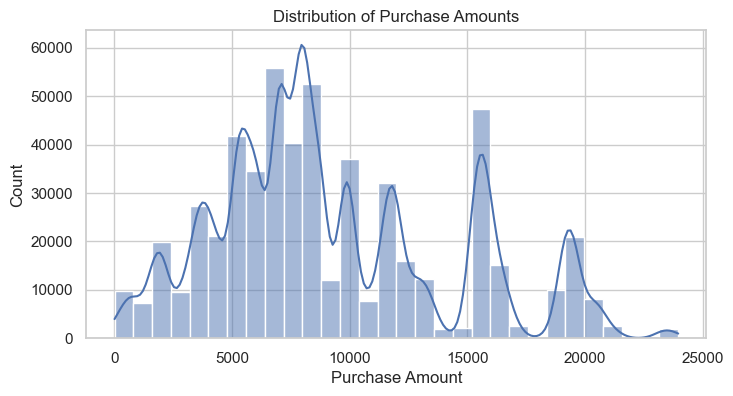

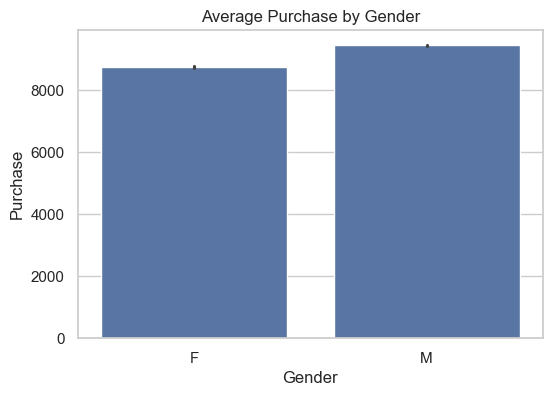

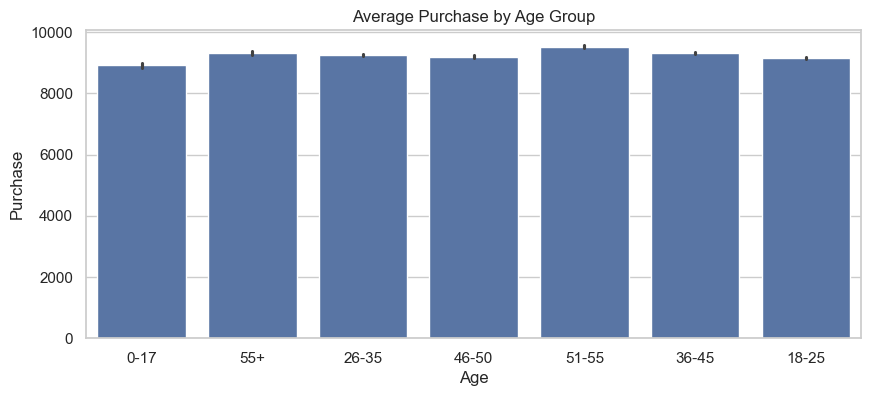

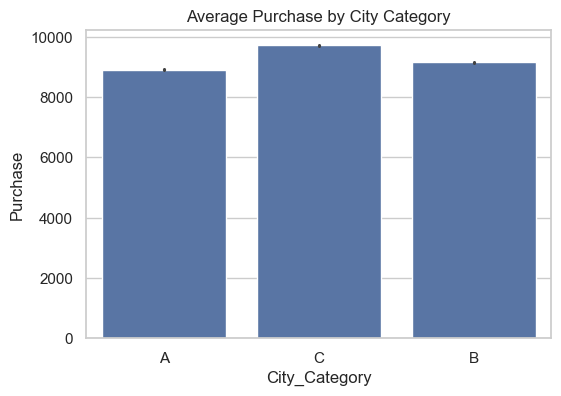

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.histplot(df['Purchase'], bins=30, kde=True)
plt.title("Distribution of Purchase Amounts")
plt.xlabel("Purchase Amount")
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x='Gender', y='Purchase', data=df)
plt.title("Average Purchase by Gender")
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x='Age', y='Purchase', data=df, estimator='mean')
plt.title("Average Purchase by Age Group")
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x='City_Category', y='Purchase', data=df)
plt.title("Average Purchase by City Category")
plt.show()


# Total purchase value (CLV)

So now we get what each user in particular spends in the website. This enables us to calculate the CLV

groupby does the deed as we can find the sum a user spent based on his user id and now we can create a new feature Total Purchaes

In [4]:
user_purchase = df.groupby('User_ID')['Purchase'].sum().reset_index(name='Total_Purchase')

## Number of orders per user

In [5]:
user_orders = df.groupby('User_ID').size().reset_index(name='Total_Orders')

# Merge both into one dataframe

In [6]:
user_df = pd.merge(user_purchase, user_orders, on='User_ID')

# Add average purchase per order

In [7]:
user_df['Avg_Purchase_Per_Order'] = user_df['Total_Purchase'] / user_df['Total_Orders']


# Add user demographic info

In [8]:


user_info = df.drop_duplicates('User_ID')[['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']]
user_df = pd.merge(user_df, user_info, on='User_ID', how='left')


# Encode categorical features

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']:
    user_df[col] = le.fit_transform(user_df[col])

print("Final Feature Set:")
print(user_df.head())


Final Feature Set:
   User_ID  Total_Purchase  Total_Orders  Avg_Purchase_Per_Order  Gender  Age  \
0  1000001          334093            35             9545.514286       0    0   
1  1000002          810472            77            10525.610390       1    6   
2  1000003          341635            29            11780.517241       1    2   
3  1000004          206468            14            14747.714286       1    4   
4  1000005          821001           106             7745.292453       1    2   

   Occupation  City_Category  Stay_In_Current_City_Years  Marital_Status  
0          10              0                           2               0  
1          16              2                           4               0  
2          15              0                           3               0  
3           7              1                           2               1  
4          20              0                           1               1  


# Using Regression


I used Linear Regression, XGBoostRegressor for thiss

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Setting target Variable


In [11]:

X = user_df.drop(['User_ID', 'Total_Purchase'], axis=1)
y = user_df['Total_Purchase']


# Split into train test sets

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train Linear Regression


In [13]:

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


# Train XGBoost

In [14]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Define Evaluation Function

In [15]:


def evaluate_model(y_true, y_pred, model_name):
    print(f"\n {model_name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R² Score:", r2_score(y_true, y_pred))

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor")



 Linear Regression Performance:
MAE: 91069.35897423865
RMSE: 164021.59021277385
R² Score: 0.9756884947370376

 XGBoost Regressor Performance:
MAE: 21638.955078125
RMSE: 134204.31468473733
R² Score: 0.9837241768836975


# C alculating Feature importances in both models

C:\Users\Jedi\AppData\Local\Temp\ipykernel_10400\933398865.py:9: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jedi\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


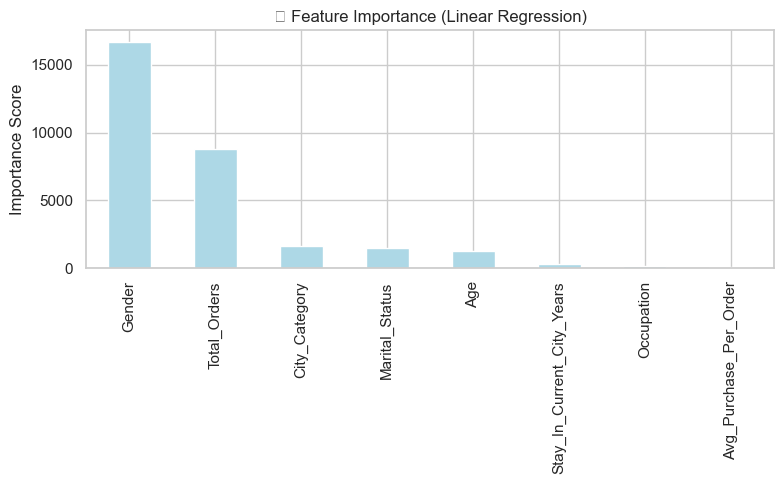

C:\Users\Jedi\AppData\Local\Temp\ipykernel_10400\933398865.py:17: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jedi\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


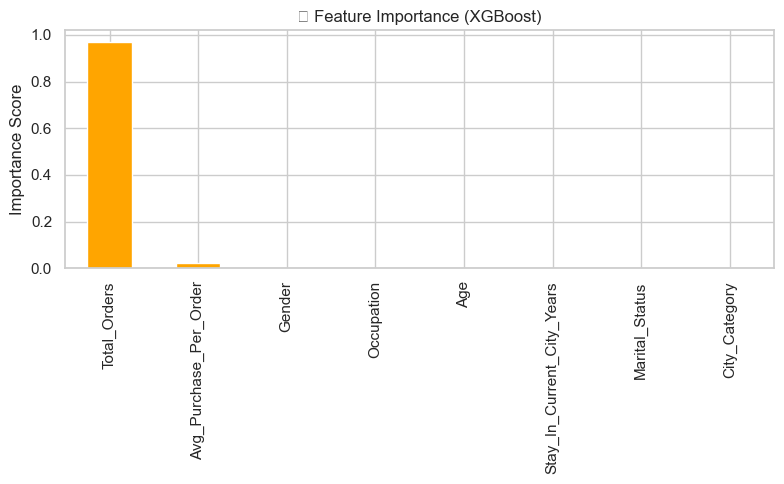

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

lr_importances = pd.Series(np.abs(lr.coef_), index=X.columns)
plt.figure(figsize=(8, 5))
lr_importances.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('🔍 Feature Importance (Linear Regression)')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns)
xgb_importances.sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title('🔥 Feature Importance (XGBoost)')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()
